# Time-Series Forecasting for Rakuten Items estimation

```
Hi Kawamoto-San,

Because I have no Rakuten's Data, please replace sunspot time-series data with real data,
If you want to multi-row data input, please change input shape and retrain.

Thank you.
```



### Visalize data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Please replace sample data in here, by Rakuten's data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2023-11-17 05:19:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-11-17 05:19:25 ERROR 404: Not Found.



In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x7a5b0be7ab90>)

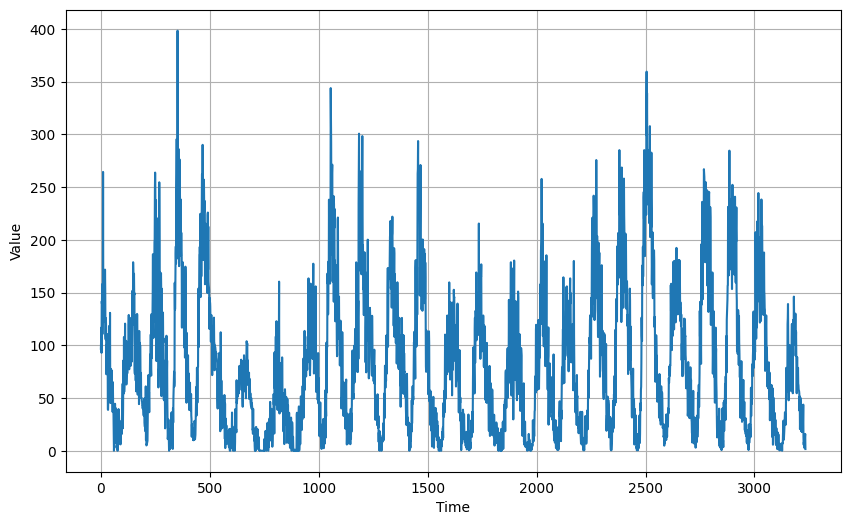

In [ ]:
# Read dataset
import csv
steps = []
sunspots = []
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    steps.append(int(row[0]))

time = np.array(steps)
series = np.array(sunspots)
plt.figure(figsize=(10, 6))
plot_series(time, series)



In [ ]:
time

array([   0,    1,    2, ..., 3232, 3233, 3234])

In [ ]:
series

array([ 96.7, 104.3, 116.7, ...,  13.2,  15.9,   1.6])

In [ ]:
# Scaler
# I'm using MinMaxScaler for normalize data, but in real, we can use Robust Scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)

[[0.24284279]
 [0.26192868]
 [0.29306881]
 ...
 [0.03314917]
 [0.03992968]
 [0.00401808]]


In [ ]:
series=series.flatten()

In [ ]:
# I'm using window slicing method
split_time = 2600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
x_train.shape

(2600,)

In [ ]:
x_valid.shape

(635,)

In [101]:
# We using shuffle for avoid overfitting
# input = 1 >> 60
# output = 2 >> 61
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [94]:
#input = 1 >> 60
#output = 61
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   ds = tf.data.Dataset.from_tensor_slices(series)
#   ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#   ds = ds.flat_map(lambda window: window.batch(window_size + 1))
#   ds = ds.shuffle(shuffle_buffer)
#   ds = ds.map(lambda window: (window[:-1], window[-1]))
#   ds = ds.batch(batch_size).prefetch(1)
#   return ds

In [102]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [103]:
list(train_set.take(1))[0][0].shape

TensorShape([32, 30, 1])

In [97]:
list(train_set.take(1))[0][1].shape

TensorShape([32, 1])

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

### We can basic using Decomposition + Moving Average with Time Slicing window + Linear layers. But now I', using DL for Demo

In [104]:
# Model 1
# If you want feed a lot of items in here please refer tensorflow example
# https://www.tensorflow.org/tutorials/structured_data/time_series
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape = (window_size, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirect  (None, 30, 64)            8704      
 ional)                                                          
                                                                 
 dense_54 (Dense)            (None, 30, 32)            2080      
                                                                 
 dense_55 (Dense)            (None, 30, 16)            528       
                                                                 
 dense_56 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 11329 (44.25 KB)
Trainable params: 11329 (44.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Model 2
# model = Sequential()
# model.add(Bidirectional(LSTM(32), input_shape = (window_size, 1)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))
# model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
# model.summary()

In [105]:
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
81/81 [==============================] - 7s 26ms/step - loss: 0.0042 - mae: 0.0610 - val_loss: 0.0014 - val_mae: 0.0372
Epoch 2/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0345 - val_loss: 9.3222e-04 - val_mae: 0.0308
Epoch 3/100
81/81 [==============================] - 1s 12ms/step - loss: 9.4608e-04 - mae: 0.0304 - val_loss: 7.4480e-04 - val_mae: 0.0279
Epoch 4/100
81/81 [==============================] - 1s 13ms/step - loss: 7.9234e-04 - mae: 0.0281 - val_loss: 6.3625e-04 - val_mae: 0.0260
Epoch 5/100
81/81 [==============================] - 1s 13ms/step - loss: 6.5713e-04 - mae: 0.0257 - val_loss: 4.6876e-04 - val_mae: 0.0223
Epoch 6/100
81/81 [==============================] - 1s 13ms/step - loss: 5.0852e-04 - mae: 0.0227 - val_loss: 3.2821e-04 - val_mae: 0.0185
Epoch 7/100
81/81 [==============================] - 1s 13ms/step - loss: 3.7608e-04 - mae: 0.0194 - val_loss: 2.3235e-04 - val_mae: 0.0149
Epoch 8/100
81/81 [=============

In [107]:
# Save model, we can prunning and quantization in here for optimize model -> speed-up for model -> We can serve more users in same time
# https://www.tensorflow.org/lite/performance/post_training_quantization
# https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide
model.save("mymodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Inference code, we can use Triton + FastAPI + Redis -> Batching input from million users to serve in large scale.

606/606 [==============================] - 3s 5ms/step


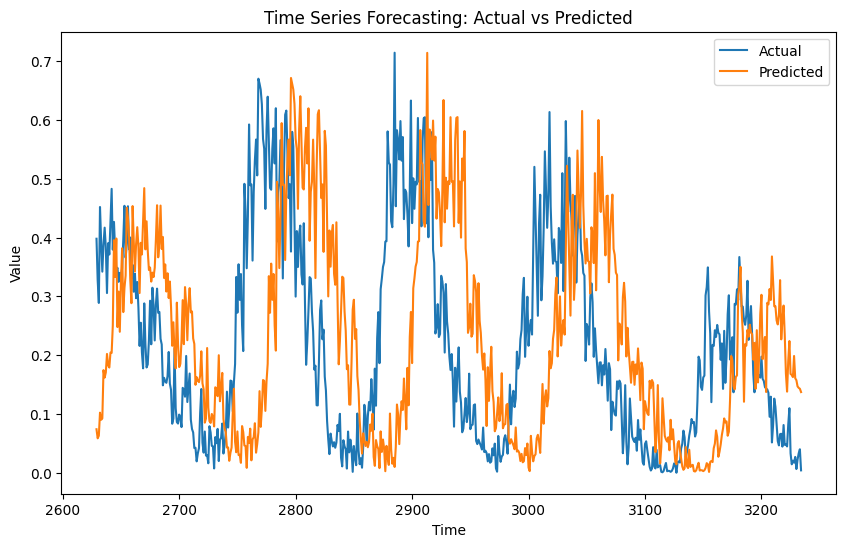

In [116]:
model.load_weights('mymodel.h5')

# Function to generate predictions using the model
def model_predict(model, series, window_size):
    # Prepare the dataset for predicting
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(1).prefetch(1)  # Predict one window at a time
    predictions = model.predict(dataset)
    # The predictions should not be flattened if the model is set up correctly
    return predictions

# Generate predictions
predictions = model_predict(model, x_valid, window_size)

# We expect the predictions to be an array with one prediction per window
expected_num_predictions = len(x_valid) - window_size + 1

# Ensure that the predictions array is the expected length
if len(predictions) != expected_num_predictions:
    raise ValueError(f"Expected number of predictions is {expected_num_predictions}, but got {len(predictions)}")

# Since the lengths now match, we can correctly create new_time_valid
new_time_valid = time_valid[window_size - 1: window_size - 1 + len(predictions)]

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(time_valid[window_size - 1:], x_valid[window_size - 1:], label="Actual")
plt.plot(new_time_valid, predictions[:, 0], label="Predicted")  # Indexing to get the first column if necessary
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Forecasting: Actual vs Predicted")
plt.legend()
plt.show()